In [2]:
import os

import numpy as np
import pandas as pd


In [3]:
train_data = pd.read_csv("../input/playground-series-s5e11/train.csv")
test_data = pd.read_csv("../input/playground-series-s5e11/test.csv")
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e11/sample_submission.csv")

# EDA

In [ ]:
# import important libraries
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

plt.style.use("ggplot")

In [6]:
print("Training Data Shape:",train_data.shape)

train_data.head()

Training Data Shape: (593994, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [7]:
print("Loan paid back percentage")
print("==" * 20 )

train_data['loan_paid_back'].value_counts(normalize=True)

Loan paid back percentage


loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

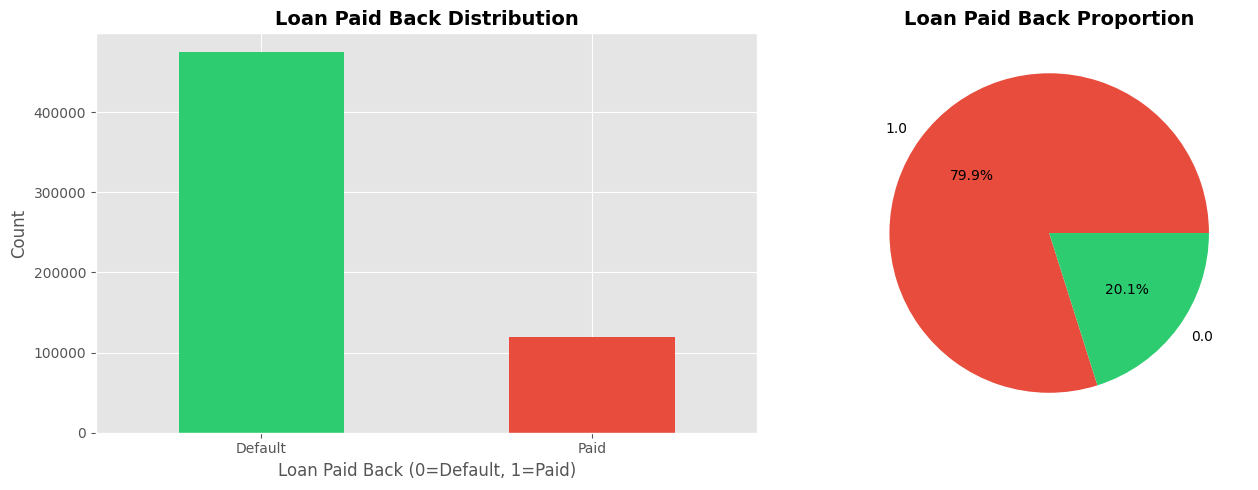

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_data['loan_paid_back'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Loan Paid Back Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Paid Back (0=Default, 1=Paid)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Default', 'Paid'], rotation=0)

train_data['loan_paid_back'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], 
                                                            autopct='%1.1f%%',
                                                            colors=['#e74c3c', '#2ecc71'])
axes[1].set_title('Loan Paid Back Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
train_data.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [11]:
pd.DataFrame(train_data.select_dtypes("O").apply(lambda x:x.unique()))

,0
gender,"[Female, Male, Other]"
marital_status,"[Single, Married, Divorced, Widowed]"
education_level,"[High School, Master's, Bachelor's, PhD, Other]"
employment_status,"[Self-employed, Employed, Unemployed, Retired, Student]"
loan_purpose,"[Other, Debt consolidation, Home, Education, Vacation, Car, Medical, Business]"
grade_subgrade,"[C3, D3, C5, F1, D1, D5, C2, C1, F5, D4, C4, D2, E5, B1, B2, F4, A4, E1, F2, B4, E4, B3, E3, B5, E2, F3, A5, A3, A1, A2]"


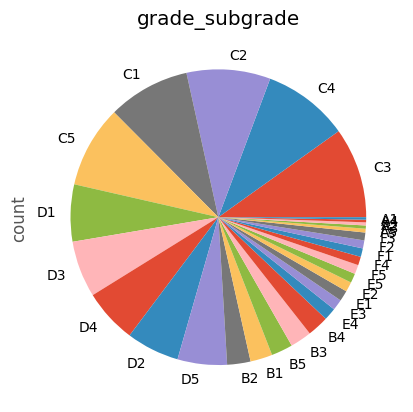

In [12]:
plt.title("grade_subgrade")
train_data.grade_subgrade.value_counts().plot.pie()
plt.show()

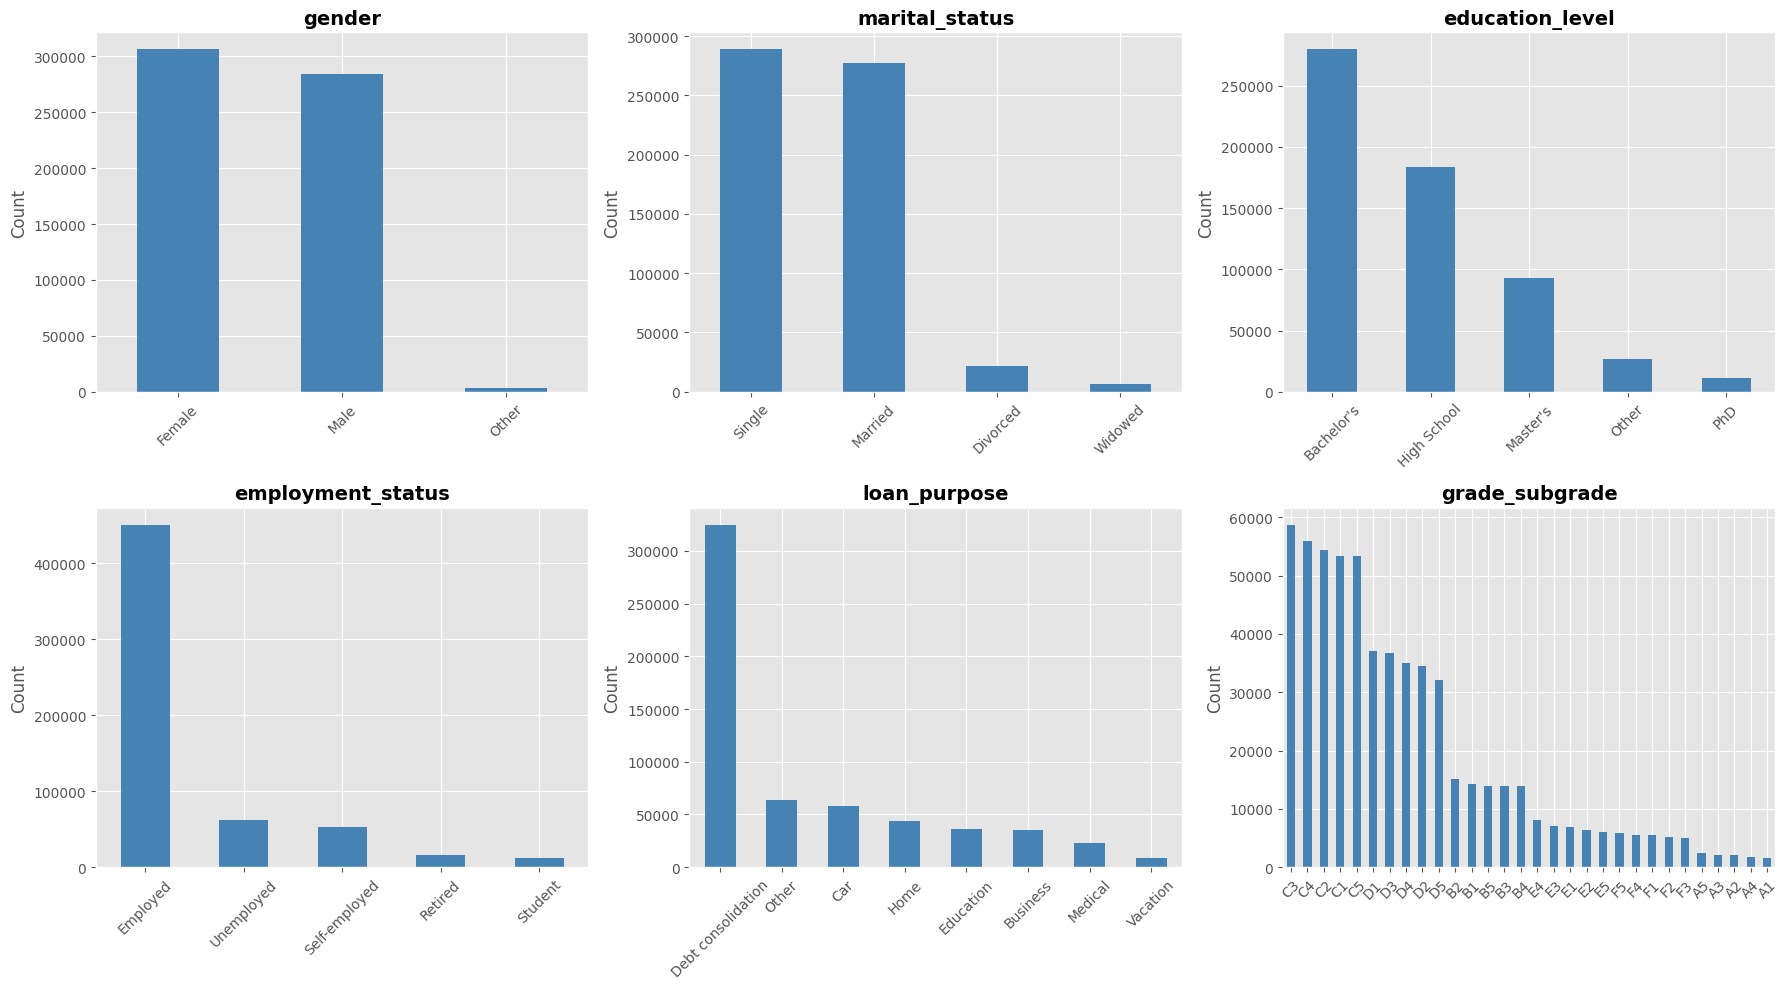

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for col, ax in zip(train_data.select_dtypes("O").columns, axes):
    train_data[col].value_counts().plot.bar(ax=ax, color='steelblue')
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Feature Engineering

- gender (3 categories)

> Female, Male, Other
>
> Distribution: Fairly balanced (~51% Female, ~48% Male, ~0.6% Other)



- marital_status (4 categories)

> Single, Married, Divorced, Widowed
>
>  Distribution: Nearly equal Single (~ 49%) and Married (~ 47%)



- education_level (5 categories)

> High School, Bachelor's, Master's, PhD, Other
>
> Order exists: This is ORDINAL data
>
> Distribution: Bachelor's dominates (~47%), then Master's (~31%)



- employment_status (5 categories)

> Employed, Self-employed, Unemployed, Retired, Student
> Distribution: Employed is majority (~76%)



- loan_purpose (8 categories)

> Debt consolidation, Home, Education, Car, Medical, Business, Vacation, Other
> 
> Distribution: Debt consolidation is largest (~55%)



- grade_subgrade (30 categories) ⭐ MOST IMPORTANT

> A1-A5, B1-B5, C1-C5, D1-D5, E1-E5, F1-F5
> 
> This is a loan risk grade - likely highly predictive!
> 
> A = Best credit risk, F = Worst credit risk
> 
> Lower number within grade = better (e.g., A1 > A5)




In [ ]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [15]:
# Get all numerical data first

X_train = train_data.drop("id", axis=1).select_dtypes("number").iloc[:,:-1]
y_train = train_data.iloc[:, -1]


In [16]:
def create_features(df, is_train=True):
    """
    Complete feature engineering - returns X_train/X_test ready for modeling
    """
    df = df.copy()
    
    # === NUMERIC FEATURES ===
    
    # Core ratios
    df['loan_to_income_ratio'] = df['loan_amount'] / (df['annual_income'] + 1)
    df['monthly_payment_estimate'] = (df['loan_amount'] * df['interest_rate'] / 100) / 12
    df['payment_to_income_ratio'] = df['monthly_payment_estimate'] / ((df['annual_income'] / 12) + 1)
    df['total_debt_estimate'] = df['annual_income'] * df['debt_to_income_ratio']
    
    # Risk indicators
    df['debt_interest_product'] = df['debt_to_income_ratio'] * df['interest_rate']
    df['high_risk_flag'] = ((df['debt_to_income_ratio'] > 0.4) & (df['interest_rate'] > 15)).astype(int)
    df['credit_quality_score'] = df['credit_score'] / (df['interest_rate'] + 1)
    
    # Log transforms
    df['annual_income_log'] = np.log1p(df['annual_income'])
    df['loan_amount_log'] = np.log1p(df['loan_amount'])
    
    # Polynomial
    df['credit_score_squared'] = df['credit_score'] ** 2
    df['debt_to_income_squared'] = df['debt_to_income_ratio'] ** 2
    
    # Binning
    df['credit_category'] = pd.cut(df['credit_score'], bins=[0, 650, 700, 750, 850], labels=[1, 2, 3, 4]).astype(int)
    df['interest_category'] = pd.cut(df['interest_rate'], bins=[0, 10, 13, 16, 30], labels=[1, 2, 3, 4]).astype(int)
    
    # === CATEGORICAL FEATURES ===
    
    # Education - Ordinal
    education_order = {'Other': 0, 'High School': 1, 'Bachelor\'s': 2, 'Master\'s': 3, 'PhD': 4}
    df['education_ordinal'] = df['education_level'].map(education_order)
    
    # Grade/Subgrade - Ordinal (MOST IMPORTANT!)
    grade_order = {
        'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5,
        'B1':6, 'B2':7, 'B3':8, 'B4':9, 'B5':10,
        'C1':11, 'C2':12, 'C3':13, 'C4':14, 'C5':15,
        'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20,
        'E1':21, 'E2':22, 'E3':23, 'E4':24, 'E5':25,
        'F1':26, 'F2':27, 'F3':28, 'F4':29, 'F5':30
    }
    df['grade_subgrade_ordinal'] = df['grade_subgrade'].map(grade_order)
    
    # Extract grade components
    df['grade_letter'] = df['grade_subgrade'].str[0]
    df['grade_number'] = df['grade_subgrade'].str[1].astype(int)
    grade_letter_order = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6}
    df['grade_letter_ordinal'] = df['grade_letter'].map(grade_letter_order)
    df['high_grade_risk'] = (df['grade_letter_ordinal'] >= 4).astype(int)
    
    # One-hot encoding
    df = pd.get_dummies(df, columns=['gender'], prefix='gender', drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['marital_status'], prefix='marital', drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['employment_status'], prefix='employment', drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['loan_purpose'], prefix='purpose', drop_first=True, dtype=int)
    
    # === INTERACTION FEATURES ===
    df['grade_income_interaction'] = df['grade_subgrade_ordinal'] * df['annual_income_log']
    df['credit_grade_interaction'] = df['credit_score'] * df['grade_letter_ordinal']
    
    # === CLEANUP ===
    drop_cols = ['education_level', 'grade_subgrade', 'grade_letter', 'id']
    
    if is_train and 'loan_paid_back' in df.columns:
        y = df['loan_paid_back']
        drop_cols.append('loan_paid_back')
    else:
        y = None
    
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])
    
    return df, y

X, y = create_features(train_data, is_train=True)
X_test, _ = create_features(test_data, is_train=False)

In [17]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, stratify = y, random_state=7, test_size=0.2)

# Train Machine Learning Models

## Baseline Model (Logistic Regression)

In [16]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)

/home/noelyang/Predicting-Loan-Payback/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [17]:
y_validation_pred = baseline_model.predict(X_validation)
f1_score(y_validation, y_validation_pred)

0.8903674347069346

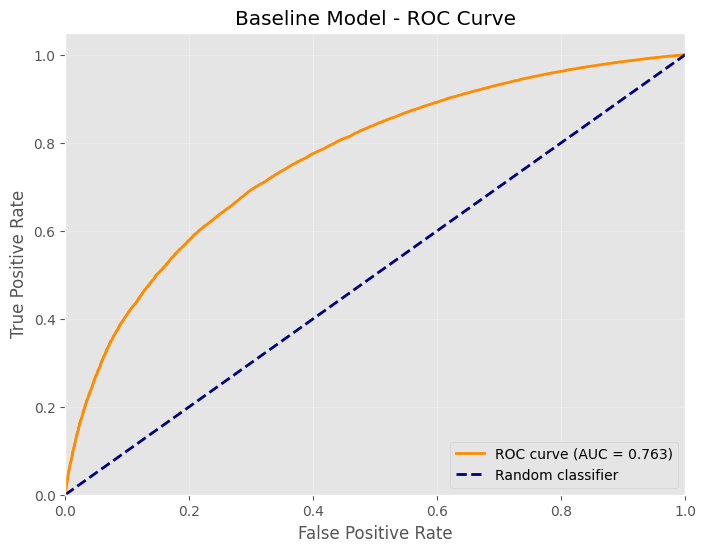

AUC Score: 0.763


In [18]:
y_probs = baseline_model.predict_proba(X_train)

y_validation_probs = baseline_model.predict_proba(X_validation)[:, 1]

fpr, tpr, thresholds = roc_curve(y_validation, y_validation_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model - ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.3f}")

In [19]:
test_probs = baseline_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_validation_probs)
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.3f}")
test_predictions = (test_probs >= optimal_threshold).astype(int)
submission = pd.DataFrame({
    'id': test_data["id"],
    'loan_paid_back': test_predictions
})

Optimal threshold: 0.804


In [20]:
submission.to_csv('submission.csv', index=False)
print(submission['loan_paid_back'].value_counts())

loan_paid_back
1    155637
0     98932
Name: count, dtype: int64


In [30]:
import warnings

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import (
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, random_state=7, class_weight="balanced"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=7,
        n_jobs=-1,
    ),
    "Extra Trees": ExtraTreesClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=7,
        n_jobs=-1,
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        random_state=7,
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        random_state=7,
        eval_metric="logloss",
        use_label_encoder=False,
        n_jobs=-1,
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=7,
        verbose=-1,
        n_jobs=-1,
    ),
    "CatBoost": CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        l2_leaf_reg=3,
        random_state=7,
        verbose=0,
        thread_count=-1,
    ),
}

# 設置交叉驗證
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# 儲存結果
results = {}

print("=" * 60)
print("Model Comparison with 5-Fold Cross-Validation")
print("=" * 60)
print()


Model Comparison with 5-Fold Cross-Validation



In [ ]:
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from tqdm.auto import tqdm


def comprehensive_cv_evaluation(models: Dict, X_train, y_train, cv, metrics=None):
    """
    完整的交叉驗證評估，包含多個指標
    """
    if metrics is None:
        metrics = {
            'AUC': roc_auc_score,
            'Accuracy': accuracy_score,
            'F1': f1_score,
            'Precision': precision_score,
            'Recall': recall_score
        }
    
    results = {model_name: {metric: [] for metric in metrics} 
               for model_name in models}
    
    # 訓練時間記錄
    training_times = {model_name: [] for model_name in models}
    
    print("=" * 70)
    print(f"{'Model':<20} {'Fold':<6} {'AUC':<8} {'Acc':<8} {'F1':<8} {'Time(s)':<8}")
    print("=" * 70)
    
    for name, model in tqdm(models.items(), desc="Models", position=0):
        
        for fold_idx, (train_idx, val_idx) in enumerate(
            tqdm(cv.split(X_train, y_train), 
                 desc=f"  {name[:15]:<15}",
                 total=cv.get_n_splits(),
                 position=1,
                 leave=False),
            1
        ):
            # 分割數據
            X_fold_train = X_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_val = y_train.iloc[val_idx]
            
            # 訓練模型並計時
            import time
            start_time = time.time()
            
            model_clone = clone(model)
            model_clone.fit(X_fold_train, y_fold_train)
            
            training_time = time.time() - start_time
            training_times[name].append(training_time)
            
            # 預測
            y_pred_proba = model_clone.predict_proba(X_fold_val)[:, 1]
            y_pred = model_clone.predict(X_fold_val)
            
            # 計算各種指標
            fold_results = {}
            fold_results['AUC'] = roc_auc_score(y_fold_val, y_pred_proba)
            fold_results['Accuracy'] = accuracy_score(y_fold_val, y_pred)
            fold_results['F1'] = f1_score(y_fold_val, y_pred)
            fold_results['Precision'] = precision_score(y_fold_val, y_pred)
            fold_results['Recall'] = recall_score(y_fold_val, y_pred)
            
            # 儲存結果
            for metric in metrics:
                results[name][metric].append(fold_results[metric])
            
            # 輸出進度
            tqdm.write(
                f"{name:<20} Fold {fold_idx:<2}: "
                f"AUC={fold_results['AUC']:.4f}  "
                f"Acc={fold_results['Accuracy']:.4f}  "
                f"F1={fold_results['F1']:.4f}  "
                f"Time={training_time:.2f}s"
            )
    
    print("=" * 70)
    
    # 整理結果為DataFrame
    summary_data = []
    for model_name in models:
        for metric in metrics:
            scores = results[model_name][metric]
            summary_data.append({
                'Model': model_name,
                'Metric': metric,
                'Mean': np.mean(scores),
                'Std': np.std(scores),
                'Min': np.min(scores),
                'Max': np.max(scores),
                'Scores': scores
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # 訓練時間統計
    time_df = pd.DataFrame({
        'Model': list(training_times.keys()),
        'Avg_Time': [np.mean(times) for times in training_times.values()],
        'Total_Time': [np.sum(times) for times in training_times.values()]
    })
    
    return summary_df, time_df, results

# 使用範例
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# 執行評估
summary_df, time_df, detailed_results = comprehensive_cv_evaluation(
    models, X_train, y_train, cv
)

# 顯示摘要
print("\n" + "="*70)
print("SUMMARY BY METRIC")
print("="*70)

pivot_table = summary_df.pivot_table(
    values='Mean', 
    index='Model', 
    columns='Metric'
).round(4)

# 加入標準差
for metric in ['AUC', 'F1', 'Accuracy']:
    if metric in pivot_table.columns:
        std_values = summary_df[summary_df['Metric'] == metric].set_index('Model')['Std']
        pivot_table[f'{metric}_std'] = std_values.round(4)

print(pivot_table)

print("\n" + "="*70)
print("TRAINING TIME COMPARISON")
print("="*70)
print(time_df.sort_values('Avg_Time'))

Model                Fold   AUC      Acc      F1       Time(s) 


Models:   0%|          | 0/7 [00:00<?, ?it/s]

  Logistic Regres:   0%|          | 0/5 [00:00<?, ?it/s]

Logistic Regression  Fold 1 : AUC=0.8593  Acc=0.8108  F1=0.8747  Time=94.07s
Logistic Regression  Fold 2 : AUC=0.8534  Acc=0.7960  F1=0.8633  Time=95.56s
Logistic Regression  Fold 3 : AUC=0.8026  Acc=0.7355  F1=0.8171  Time=89.83s
Logistic Regression  Fold 4 : AUC=0.8523  Acc=0.7970  F1=0.8642  Time=92.22s
Logistic Regression  Fold 5 : AUC=0.8591  Acc=0.8043  F1=0.8696  Time=95.98s


  Random Forest  :   0%|          | 0/5 [00:00<?, ?it/s]

Random Forest        Fold 1 : AUC=0.9148  Acc=0.9036  F1=0.9422  Time=12.01s
Random Forest        Fold 2 : AUC=0.9139  Acc=0.9032  F1=0.9419  Time=12.76s
Random Forest        Fold 3 : AUC=0.9143  Acc=0.9027  F1=0.9416  Time=12.65s
Random Forest        Fold 4 : AUC=0.9139  Acc=0.9025  F1=0.9416  Time=12.69s
Random Forest        Fold 5 : AUC=0.9125  Acc=0.9020  F1=0.9412  Time=13.44s


  Extra Trees    :   0%|          | 0/5 [00:00<?, ?it/s]

Extra Trees          Fold 1 : AUC=0.9130  Acc=0.9021  F1=0.9416  Time=5.88s
Extra Trees          Fold 2 : AUC=0.9118  Acc=0.9025  F1=0.9418  Time=5.66s
Extra Trees          Fold 3 : AUC=0.9126  Acc=0.9022  F1=0.9416  Time=5.59s
Extra Trees          Fold 4 : AUC=0.9124  Acc=0.9014  F1=0.9412  Time=5.61s
Extra Trees          Fold 5 : AUC=0.9106  Acc=0.9010  F1=0.9409  Time=5.78s


  Gradient Boosti:   0%|          | 0/5 [00:00<?, ?it/s]

Gradient Boosting    Fold 1 : AUC=0.9202  Acc=0.9062  F1=0.9435  Time=439.37s
Gradient Boosting    Fold 2 : AUC=0.9195  Acc=0.9064  F1=0.9437  Time=441.55s
Gradient Boosting    Fold 3 : AUC=0.9201  Acc=0.9058  F1=0.9433  Time=455.86s
Gradient Boosting    Fold 4 : AUC=0.9195  Acc=0.9061  F1=0.9435  Time=457.52s
Gradient Boosting    Fold 5 : AUC=0.9184  Acc=0.9055  F1=0.9431  Time=456.62s


  XGBoost        :   0%|          | 0/5 [00:00<?, ?it/s]

XGBoost              Fold 1 : AUC=0.9201  Acc=0.9040  F1=0.9423  Time=1.86s
XGBoost              Fold 2 : AUC=0.9194  Acc=0.9048  F1=0.9428  Time=1.76s
XGBoost              Fold 3 : AUC=0.9203  Acc=0.9046  F1=0.9426  Time=1.39s
XGBoost              Fold 4 : AUC=0.9192  Acc=0.9044  F1=0.9426  Time=1.79s
XGBoost              Fold 5 : AUC=0.9181  Acc=0.9035  F1=0.9420  Time=1.52s


  LightGBM       :   0%|          | 0/5 [00:00<?, ?it/s]

LightGBM             Fold 1 : AUC=0.9202  Acc=0.9046  F1=0.9427  Time=1.76s
LightGBM             Fold 2 : AUC=0.9200  Acc=0.9060  F1=0.9435  Time=1.73s
LightGBM             Fold 3 : AUC=0.9209  Acc=0.9052  F1=0.9430  Time=1.59s
LightGBM             Fold 4 : AUC=0.9198  Acc=0.9052  F1=0.9431  Time=1.79s
LightGBM             Fold 5 : AUC=0.9187  Acc=0.9046  F1=0.9426  Time=1.83s


  CatBoost       :   0%|          | 0/5 [00:00<?, ?it/s]

CatBoost             Fold 1 : AUC=0.9189  Acc=0.9050  F1=0.9429  Time=2.29s
CatBoost             Fold 2 : AUC=0.9180  Acc=0.9057  F1=0.9433  Time=2.29s
CatBoost             Fold 3 : AUC=0.9190  Acc=0.9047  F1=0.9428  Time=2.19s
CatBoost             Fold 4 : AUC=0.9182  Acc=0.9047  F1=0.9427  Time=2.02s
CatBoost             Fold 5 : AUC=0.9168  Acc=0.9042  F1=0.9425  Time=2.03s

SUMMARY BY METRIC
Metric                  AUC  Accuracy      F1  Precision  Recall  AUC_std  \
Model                                                                       
CatBoost             0.9182    0.9049  0.9428     0.9066  0.9821   0.0008   
Extra Trees          0.9121    0.9018  0.9414     0.8995  0.9875   0.0008   
Gradient Boosting    0.9196    0.9060  0.9434     0.9083  0.9814   0.0006   
LightGBM             0.9199    0.9051  0.9430     0.9069  0.9820   0.0007   
Logistic Regression  0.8453    0.7887  0.8578     0.9255  0.7997   0.0216   
Random Forest        0.9139    0.9028  0.9417     0.9036  0.98